In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

plt.style.use('seaborn-notebook')

In [12]:
DATA_FILE = '../data/level5_1000.csv'

In [13]:
df = pd.read_csv(DATA_FILE)
df = df.set_index('rid')

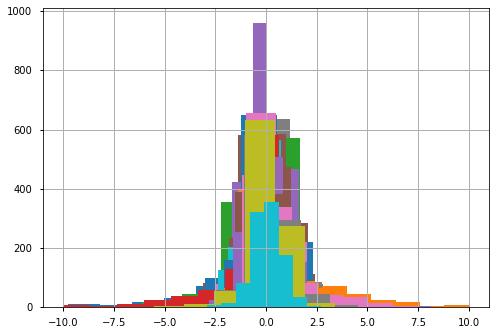

In [14]:
for i in range(50):
    row1_values = pd.Series(df.iloc[i].values)
    row1_values[row1_values < 100].hist()

In [15]:
df.head()

,CPC005_A375_6H:BRD-A85280935-003-01-7:10,CPC005_A375_6H:BRD-A07824748-001-02-6:10,CPC004_A375_6H:BRD-K20482099-001-01-1:10,CPC005_A375_6H:BRD-K62929068-001-03-3:10,CPC005_A375_6H:BRD-K43405658-001-01-8:10,CPC004_A375_6H:BRD-K03670461-001-02-0:10,CPC004_A375_6H:BRD-K36737713-001-01-6:10,CPC005_A375_6H:BRD-K51223576-001-01-3:10,CPC004_A375_6H:BRD-A14966924-001-03-0:10,CPC004_A375_6H:BRD-K79131256-001-08-8:10,...,CPC005_A375_24H:BRD-A59303141-001-03-9:10,CPC005_A375_24H:BRD-K54665485-001-04-6:10,CPC005_A375_24H:BRD-A54236247-003-03-5:10,CPC005_A375_24H:BRD-K10098805-001-02-0:10,CPC005_A375_24H:BRD-K13725475-001-02-4:10,CPC005_A375_24H:BRD-A08003242-001-02-7:10,CPC005_A375_24H:BRD-K43796186-001-01-1:10,CPC005_A375_24H:BRD-K83063356-003-01-7:10,CPC005_A375_24H:BRD-K86600316-003-01-2:10,CPC005_A375_24H:BRD-A92585442-237-01-0:10
rid,,,,,,,,,,,,,,,,,,,,,
5720,0.773769,-0.645586,-5.449666,0.193408,1.006298,-5.388713,-1.000240,0.490110,0.063297,0.560929,...,0.160586,-0.193009,0.247968,0.384757,0.352685,-0.233490,0.281433,1.141963,-0.302364,1.025050
466,-0.818468,-0.810749,2.393775,-0.582243,0.455536,1.867731,-1.106092,0.595174,-0.962553,-0.656688,...,0.161364,-0.244689,0.559568,0.592947,-1.140376,-2.413500,-1.134386,0.623217,-0.170404,0.265432
6009,0.189572,0.459060,1.279790,-0.178977,0.631738,0.281383,-0.422545,-0.224163,0.521552,0.520286,...,-0.663482,-0.235831,0.684576,1.720635,-0.254450,-0.414349,-0.796767,0.418341,0.870858,-0.539486
2309,-0.146031,-0.224676,2.167868,-1.182025,-0.936414,1.378175,0.406279,-0.244783,0.182361,-0.315654,...,0.552385,0.218920,-0.601392,-0.404516,0.662811,1.789149,0.664427,1.452139,-0.774794,-0.752421
387,-0.654002,-0.335681,2.333199,-1.012651,-1.213203,1.290522,-0.218671,-0.124029,0.572183,-0.187850,...,-0.373290,1.054628,0.458266,0.077265,0.079647,-1.665797,-0.323780,0.285577,0.879944,0.504271


In [16]:
# Rows are genes
# Columns are perturbations
# Each perturbation is a combo of perturbagen, plus random other metadata
# Inc. cell line, dosage, etc.
# Unit is log2 of fold change
# Value 1: twofold increase in expression compared to untreated
# Value 2: fourfold increase
# Value -1: twofold decrease

perturbagens = df.columns

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [18]:
class Lincs(Dataset):

    def __init__(self, df):
        super().__init__()
        self.df = df
    
    def shape(self):
        return self.df.shape
    
    def __len__(self):
        return self.df.shape[1]-1
    
    def __getitem__(self, idx):
        return torch.as_tensor(self.df.iloc[:,idx+1].values, dtype=torch.float32)

lincs = Lincs(df)
dloader = DataLoader(lincs, batch_size=32)

In [52]:
class VAE(nn.Module):
    def __init__(self, input_shape, dim_1, dim_2):
        super().__init__()
        self.fc1 = nn.Linear(input_shape, dim_1)
        self.fc2 = nn.Linear(dim_1, dim_1)
        self.enc_mu = nn.Linear(dim_1, dim_2)
        self.enc_logvar = nn.Linear(dim_1, dim_2)
        
        self.fc_out1 = nn.Linear(dim_2, dim_1)
        self.fc_out2 = nn.Linear(dim_1, dim_1)
        self.out = nn.Linear(dim_1, input_shape)
            
    def encode(self, x):
        hid = F.relu(self.fc1(x))
        hid = F.relu(self.fc2(hid))
        return self.enc_mu(hid), self.enc_logvar(hid)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        hid = F.relu(self.fc_out1(z))
        hid = F.relu(self.fc_out2(hid))
        return self.out(hid)
    
    def forward(self, t):
        mu, logvar = self.encode(t)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar        

In [62]:
def loss_function(recon_x, x, mu, logvar):
    mse = F.mse_loss(x, recon_x, reduction='sum')
    kld = 0.5*(mu.pow(2).sum(dim=-1) + torch.exp(logvar).sum(dim=-1) - (logvar+1).sum(dim=-1))
    
    return (mse + kld).sum(dim=-1)

def train(epoch):
    
    model.train()
    train_loss = 0
    for batch_idx, x in enumerate(dloader):
        x = x.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss = loss_function(recon_batch, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss / len(dloader)

def run(epochs=1000):

    train_losses = []
    for epoch in range(1000):
        train_losses.append(train(epoch))
        if epoch % 100 == 0:
            print(f'=======> Epoch: {epoch} Average loss: {train_losses[-1]}')
    plt.plot(np.arange(len(train_losses)), train_losses)

In [63]:
# for dims in [(64, 7), (64, 32), (256, 128), (256, 32), (128, 32), (128, 64)]:
for dims in [(64, 7)]:
    dim_1 = dims[0]
    dim_2 = dims[1]

    seed = 2
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)

    model = VAE(lincs.shape()[0], dim_1=dim_1, dim_2=dim_2)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print(dims)
    run(epochs=500)

(64, 7)
=======> Epoch: 0 Average loss: 10067395.475585938
=======> Epoch: 100 Average loss: 5544551.1572265625
=======> Epoch: 200 Average loss: 4741524.720703125
=======> Epoch: 300 Average loss: 4618988.9462890625


KeyboardInterrupt: 

In [66]:
df[df.columns[:200]].corr().

,CPC005_A375_6H:BRD-A85280935-003-01-7:10,CPC005_A375_6H:BRD-A07824748-001-02-6:10,CPC004_A375_6H:BRD-K20482099-001-01-1:10,CPC005_A375_6H:BRD-K62929068-001-03-3:10,CPC005_A375_6H:BRD-K43405658-001-01-8:10,CPC004_A375_6H:BRD-K03670461-001-02-0:10,CPC004_A375_6H:BRD-K36737713-001-01-6:10,CPC005_A375_6H:BRD-K51223576-001-01-3:10,CPC004_A375_6H:BRD-A14966924-001-03-0:10,CPC004_A375_6H:BRD-K79131256-001-08-8:10,...,CPC005_A375_6H:DMSO:-666,CPC004_A375_6H:BRD-K38305202-001-08-3:10,CPC004_A375_6H:BRD-A49160188-003-04-4:10,CPC004_A375_6H:BRD-K37694030-003-05-1:10,CPC004_A375_6H:BRD-A52530684-001-01-1:10,CPC004_A375_6H:BRD-A44008656-036-15-9:10,CPC005_A375_6H:BRD-K99922388-001-01-2:10,CPC004_A375_6H:BRD-K97158071-001-08-2:10,CPC004_A375_6H:BRD-K71103788-003-04-7:10,CPC005_A375_6H:BRD-K42095107-001-08-0:10
CPC005_A375_6H:BRD-A85280935-003-01-7:10,1.000000,0.479728,0.229157,0.314778,0.284657,0.138187,-0.008612,-0.041832,0.039440,-0.205303,...,-0.211612,0.007338,0.005628,-0.185269,0.320571,-0.078749,0.130024,-0.039199,-0.209273,0.103955
CPC005_A375_6H:BRD-A07824748-001-02-6:10,0.479728,1.000000,0.260513,0.208645,0.426841,0.210424,0.030799,0.009125,0.261881,-0.285435,...,-0.309178,-0.015881,-0.006045,-0.246065,0.449605,-0.032968,0.246725,-0.016071,-0.293622,0.280075
CPC004_A375_6H:BRD-K20482099-001-01-1:10,0.229157,0.260513,1.000000,0.058531,0.174819,0.547523,-0.154128,-0.030688,-0.027892,-0.333702,...,-0.186257,-0.187841,0.284491,-0.196495,0.361134,-0.286086,0.058457,-0.116273,-0.259532,0.149903
CPC005_A375_6H:BRD-K62929068-001-03-3:10,0.314778,0.208645,0.058531,1.000000,0.135741,0.039514,0.035599,-0.048523,0.024907,-0.163805,...,-0.113550,-0.034348,-0.007611,0.027952,0.176382,0.107296,-0.076942,-0.027246,-0.144902,0.006782
CPC005_A375_6H:BRD-K43405658-001-01-8:10,0.284657,0.426841,0.174819,0.135741,1.000000,0.066612,0.052024,0.052009,0.114692,-0.185771,...,-0.125600,-0.026885,0.040031,-0.214803,0.335880,0.026431,0.124993,0.102970,-0.174749,0.146421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CPC004_A375_6H:BRD-A44008656-036-15-9:10,-0.078749,-0.032968,-0.286086,0.107296,0.026431,-0.273673,0.069720,0.086146,0.149473,0.217912,...,0.168392,0.123856,-0.126421,0.114385,-0.116111,1.000000,-0.058157,0.139703,0.130293,-0.044161
CPC005_A375_6H:BRD-K99922388-001-01-2:10,0.130024,0.246725,0.058457,-0.076942,0.124993,0.028986,0.018364,0.019325,0.030493,-0.033897,...,-0.075113,-0.052698,-0.059653,-0.090538,0.095469,-0.058157,1.000000,-0.046011,-0.129743,0.114120
CPC004_A375_6H:BRD-K97158071-001-08-2:10,-0.039199,-0.016071,-0.116273,-0.027246,0.102970,-0.085596,-0.031811,-0.000038,0.116993,0.142239,...,0.037123,0.055609,-0.056176,0.117432,0.015189,0.139703,-0.046011,1.000000,-0.020253,-0.067082
CPC004_A375_6H:BRD-K71103788-003-04-7:10,-0.209273,-0.293622,-0.259532,-0.144902,-0.174749,-0.212878,0.095722,-0.042231,-0.008140,0.232228,...,0.106335,0.160123,-0.087850,0.129985,-0.174234,0.130293,-0.129743,-0.020253,1.000000,-0.098349
